## Basic analysis for Sephora foundation reviews

In [304]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [394]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [395]:
reviews = pd.read_csv("./data/sephora_reviews_final.csv")

### About the dataset:

In total, our dataset consists of 275,950 foundation reviews with 28 different columns. These columns include brand, name, product id, coverage, foundation, finish, formulation, normal skin, oily skin, combo skin, dry skin, SPF, username, rating, recommend, skin type, eye color, skin tone, skin concerns, age, beauty insider, price, first submission date, last submission date, location, incentivized review, review text, brand image url, and product image url. For our purposes, we will not need to analyze every columns, but we do have comprehensive information on user preferences and profiles (i.e. age, skin type, location, rating, recommendation) , as well as product information (coverage, finish, price).

In [399]:
reviews.sample(3)

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,SPF,user_name,rating,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,price,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url
57509,bareMinerals,Original Foundation Broad Spectrum SPF 15,P61003,Medium,Radiant,Loose,True,True,True,True,True,Peonia,5,NaN,NaN,green,medium,NaN,45to54,no,29.0,2009-10-16 21:18:16,2009-10-18 16:15:10,"Toms River, NJ",NaN,I have been using Bare Escentuals for several ...,/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s192...
44729,bareMinerals,Original Foundation Broad Spectrum SPF 15,P61003,Medium,Radiant,Loose,True,True,True,True,True,NaN,5,NaN,dry,hazel,medium,NaN,over54,no,29.0,2012-08-06 15:41:32,2012-08-06 15:45:11,"The Shore, NJ",NaN,"Love this foundation. So far, 3 compliments fo...",/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s192...
235058,SEPHORA COLLECTION,8 HR Mattifying Compact Foundation,P377347,NaN,NaN,NaN,False,False,False,False,False,negarina,5,NaN,combination,brown,medium,NaN,25to34,yes,20.0,2014-04-03 00:05:04,2014-04-03 00:15:05,"Boston, MA",NaN,Very good foundation. It hides your imperfecti...,/contentimages/brands/sephoracollection/Nth_le...,https://www.sephora.com/productimages/sku/s144...


In [396]:
reviews.shape

(275950, 28)

In [400]:
#reviews.info()

### Missingness

We should also try and get an idea of our data--what do we have and what are we missing?

We can see that we have most of the important information: brand, name/product id, rating, price, and review text, as well as some other secondary information.

In [401]:
reviews.columns[reviews.isna().sum(axis = 0) == 0]

Index(['brand', 'name', 'product_id', 'normal_skin', 'oily_skin', 'combo_skin',
       'dry_skin', 'SPF', 'rating', 'price', 'first_submission_date',
       'last_submission_date', 'review_text', 'brand_image_url',
       'product_image_url'],
      dtype='object')

In [9]:
reviews.isna().sum(axis = 0)[reviews.isna().sum(axis = 0) > 0]/len(reviews)*100

coverage               31.826780
finish                 32.198587
formulation            44.085160
user_name               1.065410
recommended            70.390650
skin_type              51.308933
eye_color              35.678203
skin_tone              33.739083
skin_concerns          74.319623
age                    56.678384
beauty_insider         59.779308
location               58.768255
incentivized_review    71.218337
dtype: float64

### Descriptive Statistics

In [604]:
reviews[["rating"]].describe()

,rating
count,275950.000000
mean,4.123794
std,1.255406
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [26]:
reviews.describe(include = ["O"])

,brand,name,product_id,coverage,finish,formulation,user_name,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url
count,275950,275950,275950,188124,187098,154297,273010,81707,134363,177496,182847,70865,119546,110989,275950,275950,113779,79423,275950,275950,275950
unique,63,217,217,3,3,6,206386,2,4,5,9,15,6,4,263462,145820,20502,2,263406,63,2995
top,bareMinerals,Original Foundation Broad Spectrum SPF 15,P61003,Medium,Matte,Liquid,ashley26,True,combination,brown,light,acne,25to34,yes,2009-06-10 14:46:06,2017-12-21 19:16:19,"New York, NY",False,What a wonderful product this powder foundatio...,/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s192...
freq,36814,19292,19292,96283,85560,105485,63,64632,70739,91257,55695,37509,42920,80476,5,433,3065,75319,42,36814,19025


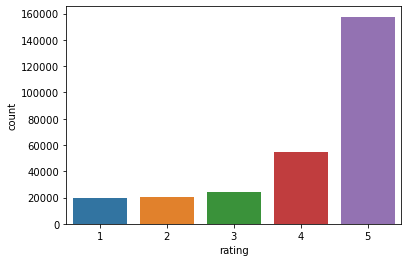

In [390]:
sns.countplot("rating", data = reviews)

We have 217 distinct foundations, coming from 63 different brands -- 14 for you Clinique, you go Clinique!

In [600]:
reviews[["brand", "name"]].drop_duplicates()[["brand"]].describe()

,brand
count,217
unique,63
top,CLINIQUE
freq,14


It does not surprise me that La Mer has a \\$120 foundation. It does surprise me that Giorgio Armani does, but I guess it's also a high-end brand. Sephora's in-house brand is the cheapest, which is unsurprising. One thing that this dataset failed to collect is the product size (i.e. fl oz.). Most foundations are 1 fl. oz., but there is some variability that could make a foundation more (or less expensive) than expected.

In [14]:
reviews[["brand", "name", "price"]].drop_duplicates().sort_values(by="price", ascending = False)

,brand,name,price
270849,Giorgio Armani Beauty,Crema Nuda,120.0
206074,La Mer,The Soft Fluid Long Wear Foundation SPF 20,120.0
206272,La Mer,The Luminous Lifting Cushion Foundation SPF 20...,120.0
192642,TOM FORD,Traceless Foundation Stick,87.0
258420,TOM FORD,Traceless Perfecting Foundation Broad Spectrum...,87.0
265980,TOM FORD,Traceless Foundation Broad Spectrum SPF 15,87.0
244734,TOM FORD,Waterproof Foundation & Concealer,87.0
222585,Dior,Capture Dreamskin Fresh & Perfect Cushion Broa...,82.0
256067,Koh Gen Do,Aqua Foundation,70.0
267347,AMOREPACIFIC,MOISTURE BOUND Tinted Treatment Moisturizer SP...,70.0


The average foundation price is \\$44.71, the cheapest being \\$18 and the priciest being \\$120, with a standard deviation of \\$15.02. Again, the foundation prices don't surprise me much since these are pretty consistent with what we would find at Sephora, which houses mainly mid-range to high-end brands.

In [210]:
reviews[["brand", "name", "price"]].drop_duplicates().describe()

,price
count,217.000000
mean,44.714286
std,15.016547
min,18.000000
25%,37.000000
50%,42.000000
75%,49.000000
max,120.000000


In [606]:
avg_price = reviews[["brand", "name", "price"]].drop_duplicates()["price"].mean()

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text xticklabel objects>)

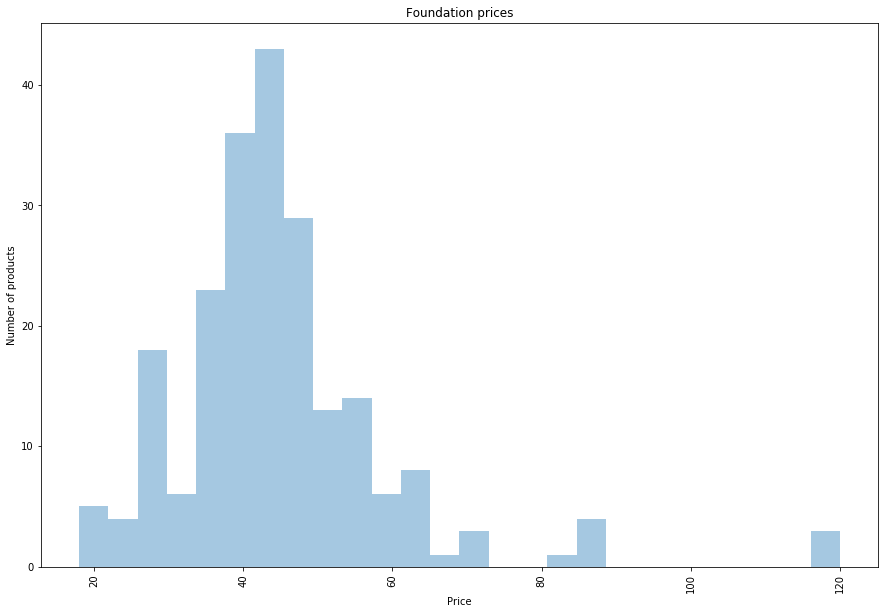

In [598]:
plt.figure(figsize = (15, 10))
sns.distplot(reviews[["brand", "name", "price"]].drop_duplicates()["price"], kde = False)
plt.title("Foundation prices")
plt.xlabel("Price")
plt.ylabel("Number of products")
plt.xticks(rotation = 90)

Average price by brand

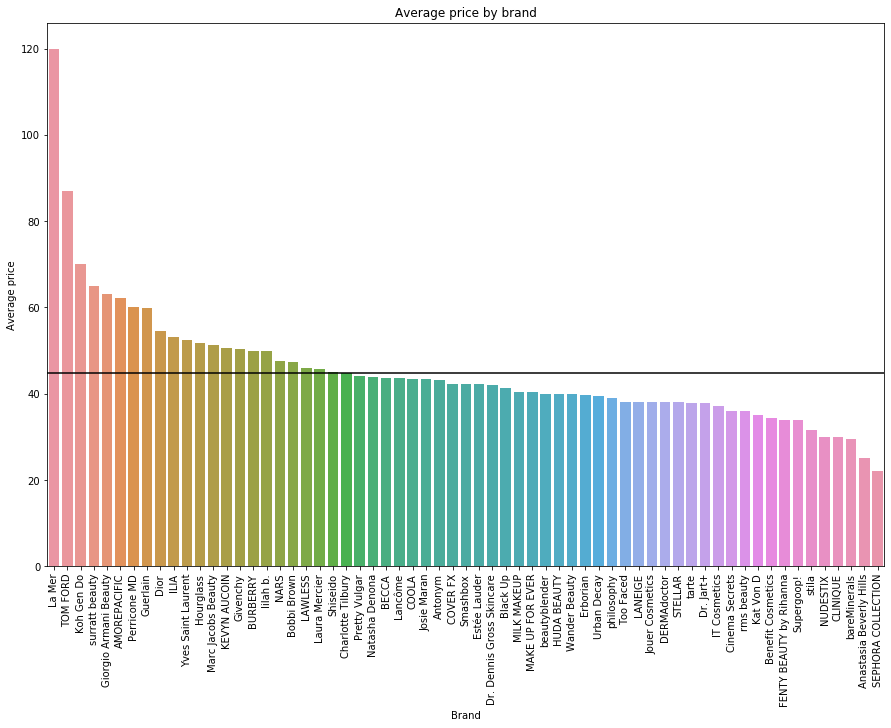

In [607]:
plt.figure(figsize = (15,10))
sns.barplot(x = reviews.groupby(["brand"]).agg({"price": "mean"}).sort_values(by = "price", ascending = False).index.to_series(), y = reviews.groupby(["brand"]).agg({"price": "mean"}).sort_values(by = "price", ascending = False)["price"], ci = None)
plt.title("Average price by brand")
plt.xlabel("Brand")
plt.ylabel("Average price")
plt.xticks(rotation = 90)
plt.axhline(y=avg_price, color='black', linestyle='-')

Average rating by brand.

In [610]:
avg_rating = reviews["rating"].mean()

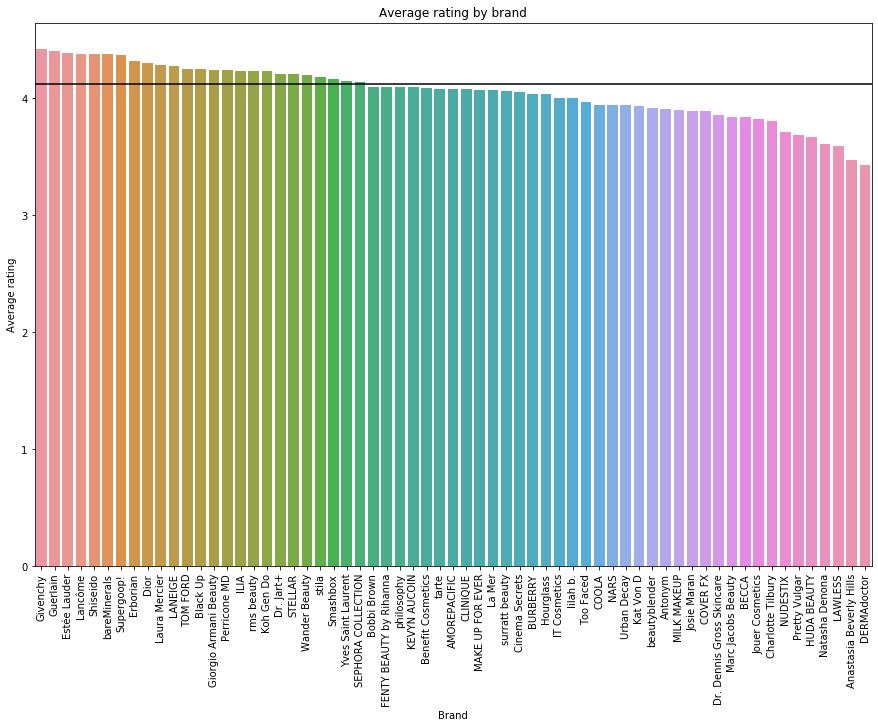

In [612]:
plt.figure(figsize = (15,10))
sns.barplot(x = reviews.groupby("brand").agg({"rating": "mean"}).sort_values(by = "rating", ascending = False).index.to_series(), y = reviews.groupby("brand").agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"], ci = None)
plt.title("Average rating by brand")
plt.xlabel("Brand")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)
plt.axhline(y=avg_rating, color='black', linestyle='-')

In [613]:
reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)

,,rating
brand,name,
lilah b.,Marvelous Matte™ Crème Foundation,4.666667
bareMinerals,Original Foundation Broad Spectrum SPF 15,4.612741
Bobbi Brown,Sheer Finish Pressed Setting Powder,4.561086
Guerlain,Lingerie De Peau Natural Perfection Foundation SPF 20,4.500978
MAKE UP FOR EVER,Duo Mat Powder Foundation,4.496236
Givenchy,Teint Couture Long-Wearing Fluid Foundation Broad Spectrum SPF 20,4.473684
Laura Mercier,Mineral Powder,4.452290
Givenchy,Teint Couture Blurring Foundation Balm Broad Spectrum 15,4.444444
CLINIQUE,Even Better™ Glow Light Reflecting Makeup Broad Spectrum SPF 15,4.441176


We can also look at how well each individual product stacks up against the average.

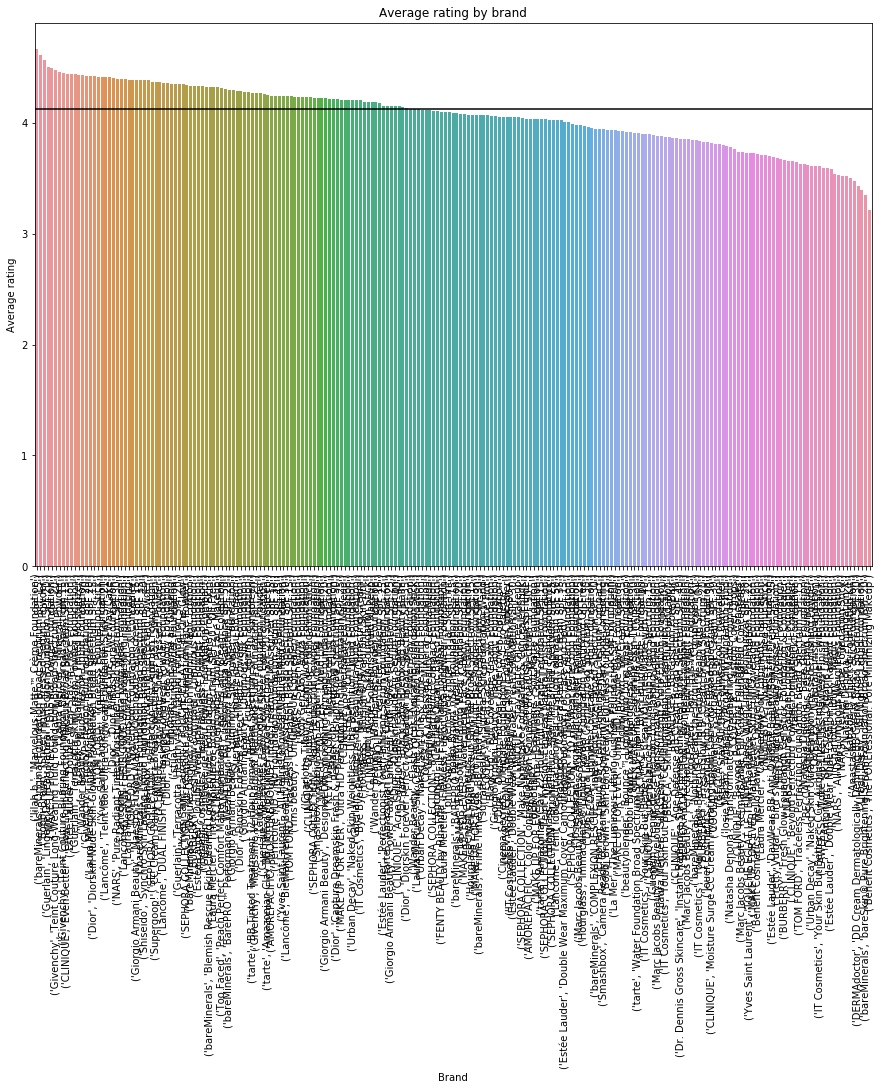

In [617]:
plt.figure(figsize = (15,10))
sns.barplot(x = reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False).index.to_series(), y = reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"], ci = None)
plt.title("Average rating by brand")
plt.xlabel("Brand")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)
plt.axhline(y=avg_rating, color='black', linestyle='-')

Products with higher than avg reviews

In [635]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] >= avg_rating])

,,rating
brand,name,
lilah b.,Marvelous Matte™ Crème Foundation,4.666667
bareMinerals,Original Foundation Broad Spectrum SPF 15,4.612741
Bobbi Brown,Sheer Finish Pressed Setting Powder,4.561086
Guerlain,Lingerie De Peau Natural Perfection Foundation SPF 20,4.500978
MAKE UP FOR EVER,Duo Mat Powder Foundation,4.496236
Givenchy,Teint Couture Long-Wearing Fluid Foundation Broad Spectrum SPF 20,4.473684
Laura Mercier,Mineral Powder,4.452290
Givenchy,Teint Couture Blurring Foundation Balm Broad Spectrum 15,4.444444
CLINIQUE,Even Better™ Glow Light Reflecting Makeup Broad Spectrum SPF 15,4.441176


10 highest-performing foundations

In [647]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] >= avg_rating]).head(10)

,,rating
brand,name,
lilah b.,Marvelous Matte™ Crème Foundation,4.666667
bareMinerals,Original Foundation Broad Spectrum SPF 15,4.612741
Bobbi Brown,Sheer Finish Pressed Setting Powder,4.561086
Guerlain,Lingerie De Peau Natural Perfection Foundation SPF 20,4.500978
MAKE UP FOR EVER,Duo Mat Powder Foundation,4.496236
Givenchy,Teint Couture Long-Wearing Fluid Foundation Broad Spectrum SPF 20,4.473684
Laura Mercier,Mineral Powder,4.452290
Givenchy,Teint Couture Blurring Foundation Balm Broad Spectrum 15,4.444444
CLINIQUE,Even Better™ Glow Light Reflecting Makeup Broad Spectrum SPF 15,4.441176


Products with lower-than-average ratings

In [636]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] < avg_rating])

,,rating
brand,name,
Wander Beauty,Flash Focus Hydrating Foundation Stick,4.123711
Laura Mercier,Silk Crème Oil Free Photo Edition Foundation,4.123269
Urban Decay,Naked Skin One & Done Hybrid Foundation,4.114416
COVER FX,Pressed Mineral Foundation,4.112676
Giorgio Armani Beauty,Crema Nuda,4.111111
SEPHORA COLLECTION,8 HR Mattifying Compact Foundation,4.109560
Antonym,Certified Organic Baked Foundation,4.103448
FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,4.098536
Laura Mercier,Flawless Fusion Ultra-Longwear Foundation,4.097918


10 lowest-performing foundations

In [648]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] < avg_rating]).tail(10)

rating
brand                   name                                                        
Charlotte Tilbury       Magic Foundation                                    3.533333
NARS                    All Day Luminous Weightless Foundation              3.526861
                        Velvet Matte Foundation Stick                       3.518692
Natasha Denona          Foundation X                                        3.515152
Kat Von D               Lock-It Foundation Kit                              3.500000
Anastasia Beverly Hills Stick Foundation                                    3.470391
DERMAdoctor             DD Cream Dermatologically Defining BB Cream Bro...  3.428571
Urban Decay             All Nighter Liquid Foundation                       3.396541
bareMinerals            bareSkin® Pure Brightening Serum Foundation Bro...  3.351675
Benefit Cosmetics       The POREfessional: Pore Minimizing Makeup           3.211538

Location data

Not a perfect fix, but we can clean up a bit of the text data for "location" to see where our reviewers/purchasers are coming from.

In [649]:
reviews["location"] = reviews["location"].str.lower().str.replace('[^\w\s]','').str.strip()

Top 10 cities/locations

In [650]:
reviews["location"].value_counts()[:10]

new york ny         3405
los angeles ca      3045
chicago il          2060
san francisco ca    1792
boston ma           1774
houston tx          1581
seattle wa          1381
san diego ca        1348
toronto on          1171
washington dc       1144
Name: location, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

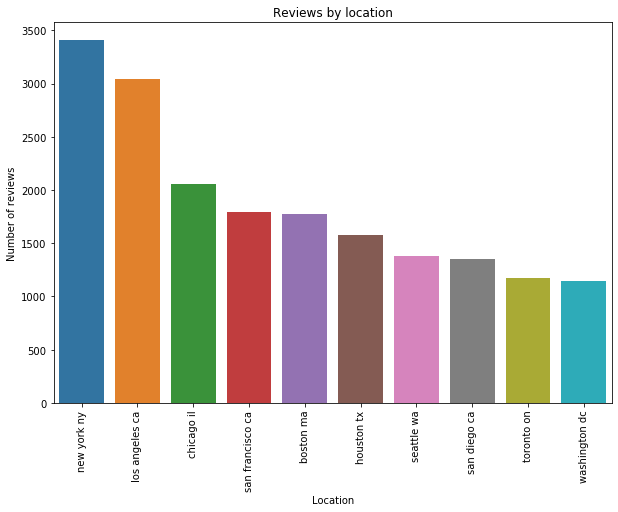

In [651]:
plt.figure(figsize = (10,7))
sns.barplot(reviews["location"].value_counts()[:10].index, reviews["location"].value_counts()[:10])
plt.title("Reviews by location")
plt.xlabel("Location")
plt.ylabel("Number of reviews")
plt.xticks(rotation = 90)

We can look at the average rating across the top 10 cities. Doesn't seem to give us any interesting information.

In [217]:
top10cities_reviews = reviews[reviews["location"].isin(reviews["location"].value_counts()[:10].index)]

In [218]:
top10cities_reviews.groupby(["location"]).agg({"rating": "mean"})

,rating
location,
boston ma,4.248027
chicago il,4.183495
houston tx,4.263757
los angeles ca,4.212808
new york ny,4.187078
san diego ca,4.222552
san francisco ca,4.147321
seattle wa,4.136133
toronto on,4.110162


In [652]:
top10cities_reviews.groupby("incentivized_review").agg({"rating": "mean"})

,rating
incentivized_review,
False,4.002791
True,4.259036


In [239]:
reviews.groupby(["age"]).agg({"rating": ["count", "mean"]})

rating          
        count      mean
age                    
13to17   5039  4.095059
18to24  34406  4.176917
25to34  42920  4.247018
35to44  18338  4.312902
45to54  11510  4.429192
over54   7333  4.433520

This is interesting! Sephora tiers are: (1) None (2) Beauty Insider (3) VIB (4) VIB Rouge. This makes sense to me since more frequent shoppers will probably be harsher with their reviews -- we have higher expectations!

In [502]:
reviews.groupby("beauty_insider").agg({"rating": "mean"})

,rating
beauty_insider,
no,4.412723
yes,4.338262
yesvib,4.064634
yesvibr,4.047964


In [519]:
#reviews.groupby(["beauty_insider", "incentivized_review"]).size()

In [520]:
#reviews[reviews["incentivized_review"].notna()].groupby("beauty_insider").size()

Proportion of incentivized vs non-incentivized review by BI status

In [518]:
reviews.groupby(["beauty_insider", "incentivized_review"]).size()/reviews[reviews["incentivized_review"].notna()].groupby("beauty_insider").size()

beauty_insider  incentivized_review
no              False                  0.724891
                True                   0.275109
yes             False                  0.834989
                True                   0.165011
yesvib          False                  0.897917
                True                   0.102083
yesvibr         False                  0.903599
                True                   0.096401
dtype: float64

## Foundation characteristics

We can look at the coverage, finish, formulation, and SPF.

In [145]:
reviews.groupby(["coverage", "finish"]).size()

coverage  finish 
Full      Matte      42619
          Natural    20400
          Radiant    11837
Light     Matte        151
          Natural    15193
          Radiant      576
Medium    Matte      42790
          Natural    32433
          Radiant    21060
dtype: int64

Most light-coverage foundations tend to have a natural finish, while most full-coverage foundations have a matte finish. This also isn't surprising, since radiant/natural foundations tend to not be as long-lasting. I am surprised that there aren't more reviews for radiant foundations, especially in the light/medium-coverage foundations, since dewy looks are trending. I don't know how old this dataset is, so it may be different today.

In [147]:
reviews.groupby(["coverage", "finish"]).agg({"rating": "mean"})

rating
coverage finish           
Full     Matte    4.090265
         Natural  3.881225
         Radiant  3.740306
Light    Matte    4.072848
         Natural  4.005200
         Radiant  3.916667
Medium   Matte    4.245548
         Natural  4.049887
         Radiant  4.548765

In [159]:
reviews.groupby(["coverage", "finish"]).agg({"rating": "mean"}).unstack()

rating                    
finish       Matte   Natural   Radiant
coverage                              
Full      4.090265  3.881225  3.740306
Light     4.072848  4.005200  3.916667
Medium    4.245548  4.049887  4.548765

In [248]:
#sns.catplot(reviews.groupby(["coverage", "finish"]).agg({"rating": "mean"}).unstack().reset_index(), hue = ")

In [198]:
reviews.groupby(["coverage", "finish"]).agg({"rating": "mean"}).unstack().xs("rating", axis = 1, drop_level = True)

finish,Matte,Natural,Radiant
coverage,,,
Full,4.090265,3.881225,3.740306
Light,4.072848,4.005200,3.916667
Medium,4.245548,4.049887,4.548765


In [247]:
#sns.catplot(reviews.groupby(["coverage", "finish"]).agg({"rating": "mean"}).unstack().xs("rating", axis = 1, drop_level = True))

In [385]:
#reviews.groupby(["SPF"])["rating"].hist()

In [386]:
#reviews["SPF"].value_counts()

In [387]:
#stats.mannwhitneyu(reviews[reviews["SPF"] == True]["rating"], reviews[reviews["SPF"] == False]["rating"])

In [388]:
#reviews.groupby(["SPF"]).agg({"rating": "mean"})

### Incentivized Reviews

In [58]:
reviews["incentivized_review"].value_counts()

False    75319
True      4104
Name: incentivized_review, dtype: int64

In [312]:
stats.mannwhitneyu(reviews[reviews["incentivized_review"] == True]["rating"], reviews[reviews["incentivized_review"] == False]["rating"])

MannwhitneyuResult(statistic=141135197.5, pvalue=1.9255991587523718e-24)

In [60]:
reviews.groupby("incentivized_review").agg({"rating": "mean"})

,rating
incentivized_review,
False,3.902256
True,4.206871


In [241]:
unbiased_reviews = reviews[reviews["incentivized_review"] == False]

In [238]:
unbiased_reviews.groupby("age").agg({"rating": ["count", "mean"]})

rating          
        count      mean
age                    
13to17   1245  3.795181
18to24   9535  3.930572
25to34   8914  3.986201
35to44   2749  4.052383
45to54   1587  4.243856
over54    868  4.243088

In [242]:
biased_reviews = reviews[reviews["incentivized_review"] == True]

In [243]:
biased_reviews.groupby("age").agg({"rating": ["count", "mean"]})

rating          
        count      mean
age                    
13to17     80  3.912500
18to24   1438  4.269124
25to34   1612  4.240695
35to44    399  4.157895
45to54    139  4.352518
over54     52  3.923077

In [246]:
reviews.groupby(["age", "incentivized_review"]).agg({"rating": ["count", "mean"]})

rating          
                            count      mean
age    incentivized_review                 
13to17 False                 1245  3.795181
       True                    80  3.912500
18to24 False                 9535  3.930572
       True                  1438  4.269124
25to34 False                 8914  3.986201
       True                  1612  4.240695
35to44 False                 2749  4.052383
       True                   399  4.157895
45to54 False                 1587  4.243856
       True                   139  4.352518
over54 False                  868  4.243088
       True                    52  3.923077

In [263]:
reviews.groupby(["age", "incentivized_review"]).agg({"rating": ["count", "mean"]})

rating          
                            count      mean
age    incentivized_review                 
13to17 False                 1245  3.795181
       True                    80  3.912500
18to24 False                 9535  3.930572
       True                  1438  4.269124
25to34 False                 8914  3.986201
       True                  1612  4.240695
35to44 False                 2749  4.052383
       True                   399  4.157895
45to54 False                 1587  4.243856
       True                   139  4.352518
over54 False                  868  4.243088
       True                    52  3.923077

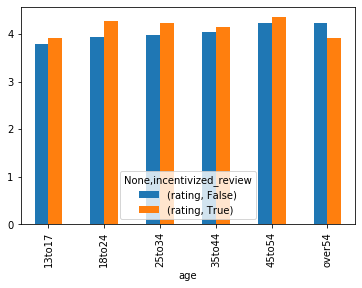

In [266]:
reviews.groupby(["age", "incentivized_review"]).agg({"rating": "mean"}).unstack().plot(kind = "bar")

AttributeError: 'Rectangle' object has no property 'stacked'

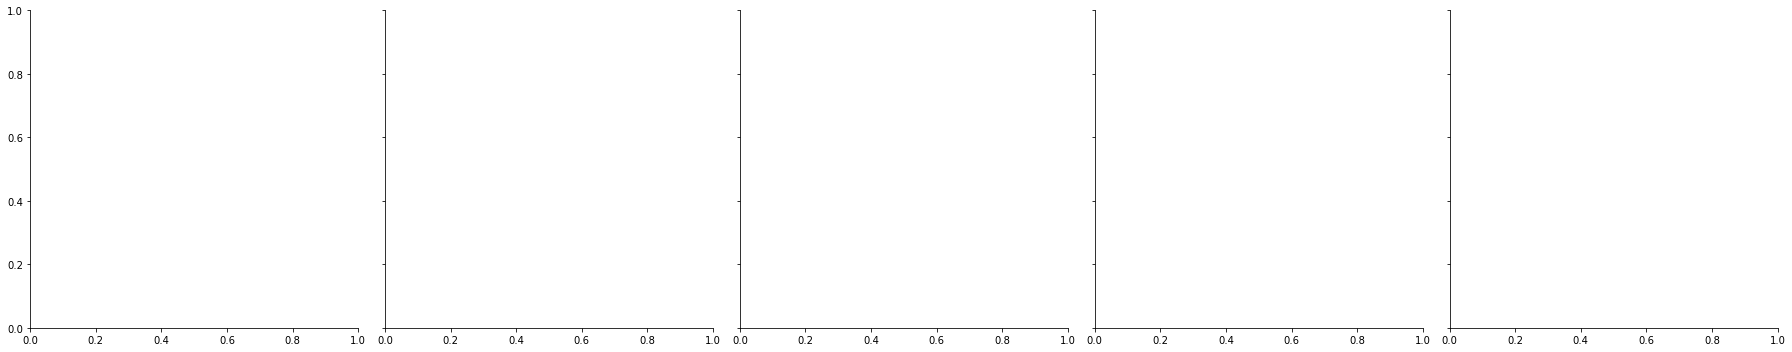

In [302]:
sns.catplot(x = "age", y = "incentivized_review", col = "rating", kind = "bar", stacked = True, data = reviews, order = sorted(reviews["age"].dropna().unique()))

Formulation

In [328]:
reviews["formulation"].value_counts()

Liquid     105487
Loose       27035
Pressed      7502
Stick        7446
Cream        6827
Name: formulation, dtype: int64

Checked online and the foundation "LiquidStick" is actually a liquid, so I just renamed it.

In [333]:
reviews["formulation"].loc[reviews["formulation"] == "LiquidStick"] = "Liquid"

In [334]:
reviews["formulation"].value_counts()

Liquid     105487
Loose       27035
Pressed      7502
Stick        7446
Cream        6827
Name: formulation, dtype: int64

In [335]:
reviews.groupby("formulation").agg({"rating": "mean"})

,rating
formulation,
Cream,4.199648
Liquid,4.027122
Loose,4.546884
Pressed,4.351373
Stick,4.026189


In [338]:
reviews[reviews["formulation"] == "Loose"][["brand", "name"]].drop_duplicates()

,brand,name
43998,bareMinerals,Original Foundation Broad Spectrum SPF 15
119844,bareMinerals,Matte Foundation Broad Spectrum SPF 15


In [373]:
reviews.groupby(["brand", "name"]).agg({"rating": ["count", "mean"]}).xs("rating", axis = 1, drop_level = True).sort_values(by = "mean", ascending = False)

,,count,mean
brand,name,,
lilah b.,Marvelous Matte™ Crème Foundation,12,4.666667
bareMinerals,Original Foundation Broad Spectrum SPF 15,19292,4.612741
Bobbi Brown,Sheer Finish Pressed Setting Powder,221,4.561086
Guerlain,Lingerie De Peau Natural Perfection Foundation SPF 20,1022,4.500978
MAKE UP FOR EVER,Duo Mat Powder Foundation,3587,4.496236
Givenchy,Teint Couture Long-Wearing Fluid Foundation Broad Spectrum SPF 20,247,4.473684
Laura Mercier,Mineral Powder,1572,4.452290
Givenchy,Teint Couture Blurring Foundation Balm Broad Spectrum 15,180,4.444444
CLINIQUE,Even Better™ Glow Light Reflecting Makeup Broad Spectrum SPF 15,68,4.441176


In [374]:
reviews.columns

Index(['brand', 'name', 'product_id', 'coverage', 'finish', 'formulation',
       'normal_skin', 'oily_skin', 'combo_skin', 'dry_skin', 'SPF',
       'user_name', 'rating', 'recommended', 'skin_type', 'eye_color',
       'skin_tone', 'skin_concerns', 'age', 'beauty_insider', 'price',
       'first_submission_date', 'last_submission_date', 'location',
       'incentivized_review', 'review_text', 'brand_image_url',
       'product_image_url'],
      dtype='object')

Skin type doesn't tell us much

In [380]:
reviews["skin_type"].value_counts()

combination    70739
oily           24996
dry            21060
normal         17568
Name: skin_type, dtype: int64

In [379]:
reviews.groupby(["skin_type"]).agg({"rating": ["count", "mean"]})

rating          
             count      mean
skin_type                   
combination  70739  4.095520
dry          21060  4.058025
normal       17568  4.121699
oily         24996  4.049488

This one will probably be a doozy!

In [381]:
reviews["skin_tone"].value_counts()

light        55695
medium       47626
fair         38879
olive        16050
deep          7735
tan           6385
porcelain     6190
dark          3687
ebony          600
Name: skin_tone, dtype: int64

In [383]:
reviews.groupby("skin_tone").agg({"rating": "mean"})

,rating
skin_tone,
dark,4.288310
deep,4.297091
ebony,4.401667
fair,4.077651
light,4.185385
medium,4.274829
olive,4.263053
porcelain,3.758805
tan,4.215035


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020690C8EF28>]],
      dtype=object)

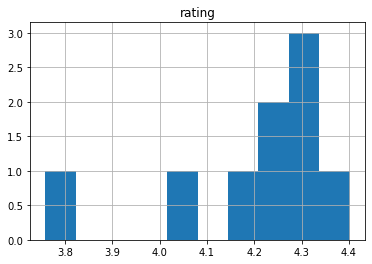

In [384]:
reviews.groupby("skin_tone").agg({"rating": "mean"}).hist()

In [410]:
reviews.groupby("recommended").agg({"rating": "mean"})

,rating
recommended,
False,1.989165
True,4.623886


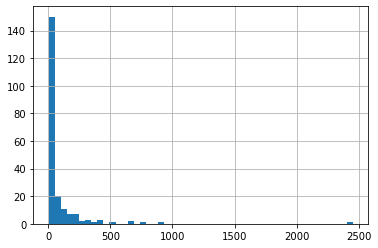

In [421]:
reviews[reviews["recommended"] == False]["name"].value_counts().hist(bins = 50)

In [432]:
reviews[reviews["recommended"] == False]["name"].value_counts()[:10]

Pro Filt'r Soft Matte Longwear Foundation                                2454
Lock-It Foundation                                                        901
Natural Radiant Longwear Foundation                                       738
#FauxFilter Foundation                                                    661
Born This Way Foundation                                                  642
Ultra HD Invisible Cover Foundation                                       533
Vanish™ Seamless Finish Foundation Stick                                  436
Shameless Youthful-Look 24H Foundation SPF 25                             410
All Nighter Liquid Foundation                                             400
Peach Perfect Comfort Matte Foundation – Peaches and Cream Collection     370
Name: name, dtype: int64

In [433]:
reviews[reviews["recommended"] == True]["name"].value_counts()[:10]

Pro Filt'r Soft Matte Longwear Foundation                                9227
Lock-It Foundation                                                       3003
Ultra HD Invisible Cover Foundation                                      2495
Peach Perfect Comfort Matte Foundation – Peaches and Cream Collection    2330
Born This Way Foundation                                                 1963
Vanish™ Seamless Finish Foundation Stick                                 1707
Shameless Youthful-Look 24H Foundation SPF 25                            1510
Double Wear Stay-in-Place Foundation                                     1429
BarePRO™ Performance Wear Liquid Foundation Broad Spectrum SPF 20        1418
Natural Radiant Longwear Foundation                                      1365
Name: name, dtype: int64

In [436]:
reviews.groupby(["brand", "name", "recommended"]).agg({"rating": ["count", "mean"]})

rating  \
                                                                                        count   
brand                   name                                               recommended          
AMOREPACIFIC            Color Control Cushion Compact Broad Spectrum SP... False           18   
                                                                           True            92   
                        MOISTURE BOUND Tinted Treatment Moisturizer SPF 15 False            3   
                                                                           True            13   
Anastasia Beverly Hills Stick Foundation                                   False          207   
...                                                                                       ...   
tarte                   BB Tinted Treatment 12-Hour Primer Broad Spectr... True           220   
                        Clay Stick Foundation                              False           96   
                                                                           True           215   
                        Water Foundation Broad Spectrum SPF 15 - Rainfo... False          308   
                                                                           True           879   

                                                                                                  
                                                                                            mean  
brand                   name                                               recommended            
AMOREPACIFIC            Color Control Cushion Compact Broad Spectrum SP... False        2.388889  
                                                                           True         4.652174  
                        MOISTURE BOUND Tinted Treatment Moisturizer SPF 15 False        2.666667  
                                                                           True         4.538462  
Anastasia Beverly Hills Stick Foundation                                   False        1.869565  
...                                                                                          ...  
tarte                   BB Tinted Treatment 12-Hour Primer Broad Spectr... True         4.713636  
                        Clay Stick Foundation                              False        1.979167  
                                                                           True         4.483721  
                        Water Foundation Broad Spectrum SPF 15 - Rainfo... False        2.107143  
                                                                           True         4.582480  

[427 rows x 2 columns]

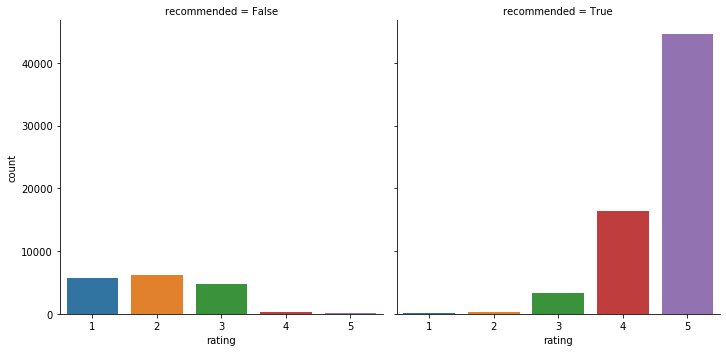

In [541]:
sns.catplot(x = "rating", col = "recommended", data = reviews, kind = "count")

In [542]:
#sns.countplot(reviews[reviews["recommended"] == False]["rating"])

In [543]:
#sns.countplot(reviews[reviews["recommended"] == True]["rating"])

In [444]:
reviews[reviews["recommended"] == False]

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,SPF,user_name,rating,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,price,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url
22,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Andrea0076,2,False,combination,brown,fair,acne,NaN,NaN,34.0,2018-11-02 16:53:33,2018-12-05 10:56:56,NaN,NaN,"I wanted to love this so much, since I had tri...",/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
27,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Marianny24,3,False,dry,brown,light,acne,NaN,NaN,34.0,2017-09-13 19:35:46,2018-12-06 11:28:46,NaN,NaN,Absolutely upset that this didn't work for me....,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
43,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,DominiqueCox,2,False,combination,NaN,tan,NaN,NaN,NaN,34.0,2018-05-12 03:05:14,2018-11-19 02:04:40,NaN,NaN,This foundation looks great when first applied...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
57,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,anna2006,1,False,oily,brown,medium,acne,NaN,NaN,34.0,2017-12-19 20:21:11,2018-11-29 21:28:12,NaN,NaN,I honestly don’t understand how people make th...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
59,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,hannahbraith,1,False,combination,hazel,light,acne,NaN,NaN,34.0,2017-12-22 05:34:25,2018-11-26 19:41:48,NaN,NaN,I want to really love this foundation. The col...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
60,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Luciaebeck,1,False,combination,blue,light,acne,NaN,NaN,34.0,2018-01-28 19:24:03,2018-11-16 01:48:55,NaN,NaN,I went to the store very excited to try this f...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
69,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Kelliet27,1,False,combination,blue,porcelain,NaN,25to34,NaN,34.0,2018-04-09 01:25:09,2018-11-22 08:15:18,NaN,NaN,"I was not a fan, horrible on dry skin. Clings ...",/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
74,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,lovelyladylocs,3,False,oily,brown,dark,cuticles,45to54,NaN,34.0,2017-09-30 00:47:23,2017-09-30 01:00:03,NaN,NaN,I have oily skin and my skin doesn't of the da...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
87,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,derya,1,False,combination,hazel,olive,acne,NaN,NaN,34.0,2018-04-02 04:24:32,2018-12-01 01:56:39,NaN,NaN,I am genuinely upset about this product. I rea...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...
88,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,myanforever,3,False,combination,brown,medium,acne,NaN,NaN,34.0,2017-11-16 21:26:10,2018-12-04 16:37:40,NaN,NaN,"As much as I wanted to like this, I couldn't g...",/contentimages/bran

## Conclusions

- Foundation prices range from \\$18 to \\$120, and are \~\\$45 on average.
- Average rating increases with age
- Incentivized ratings are higher than non-incentivized ratings on average (not surprising)

In [533]:
tags.groupby(["Value"]).agg({"Count": "sum"}).sort_values(by = "Count", ascending = False)

,Count
Value,
buildable coverage,51093.0
long wearing,34864.0
natural finish,24141.0
oil-free,20853.0
non-drying,15356.0
lightweight,11819.0
sheer coverage,9652.0
contains SPF,9046.0
moisturizing,5536.0


In [460]:
tags = pd.read_csv("./data/Sephora_Foundation_Tags.csv")

In [468]:
tags

,Count,Value,brand,product,total_review_count
0,1415.0,buildable coverage,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
1,1307.0,long wearing,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
2,567.0,oil-free,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
3,62.0,lightweight,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
4,41.0,natural,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
5,36.0,oily,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
6,35.0,natural looking,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
7,27.0,natural finish,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
8,24.0,light weight,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145
9,19.0,flawless,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,9145


In [466]:
tags.groupby(["brand", "product"]).size()

brand                    product                                                                   
AMOREPACIFIC             Color Control Cushion Compact Broad Spectrum SPF 50+                          30
                         MOISTURE BOUND Tinted Treatment Moisturizer SPF 15                            30
Anastasia Beverly Hills  Stick Foundation                                                              30
Antonym                  Certified Organic Baked Foundation                                             3
BECCA                    Aqua Luminous Perfecting Foundation                                           30
                                                                                                       ..
tarte                    Amazonian Clay BB Tinted Moisturizer Broad Spectrum SPF 20 Sunscreen          30
                         Amazonian Clay Full Coverage Airbrush Foundation                              30
                         BB Tinted Treatment 12-Hour

In [100]:
#tags["Value"].value_counts().hist()

In [101]:
#tags.groupby(["brand"]).agg({"Value": lambda x:x.value_counts()[0]})

In [102]:
#tags[["brand", "product"]]